In [1]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.observationsAndERA5.mountainUtils import *

from scipy.stats import linregress
xr.set_options(display_style='text') 

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Functions, data loading

In [2]:
topo_midres = xr.open_dataarray("/global/cscratch1/sd/qnicolas/ETOPO1_Ice_g_gmt4_coarse.nc")
topo_midres = np.maximum(0.,topo_midres)

In [3]:
Ghats      = MountainRangeCustom("ghats"      ,[64,82,7,24]   ,"Western Ghats"           ,70 ,[6,7,8]  ,[ 75  ,   9  ,  71.5, 20   ,2  ])
Myanmar    = MountainRangeCustom("myanmar"    ,[84,102,7,24]  ,"Myanmar"                 ,60 ,[6,7,8]  ,[ 98  ,  11  ,  90  , 21   ,4  ])
Vietnam    = MountainRangeCustom("vietnam"    ,[100,118,8,25] ,"Annamite range (Vietnam)",240,[10,11]  ,[108  ,  18  , 111  , 13   ,2  ])
Malaysia   = MountainRangeCustom("malaysia"   ,[96,114,-2,15] ,"Malaysia"                ,225,[11,12]  ,[102.5,   8  , 105.5,  3   ,2  ])
Philippines= MountainRangeCustom("philippines",[117,135,5,22] ,"Philippines"             ,225,[11,12]  ,[123.5,  17  , 127  ,  9   ,2  ])
Newbritain = MountainRangeCustom("newbritain" ,[145,163,-17,0],"New Britain"             ,320,[6,7,8]  ,[154  , - 5.5, 150  , -8.5 ,2  ])

MRs = (Ghats,Myanmar,Vietnam,Malaysia,Philippines,Newbritain)

for MR in MRs:
    print(MR.name)
    MR.set_daily_imerg()
    varname='GPM_PR'
    grid = MR.vars[varname+'_DAILY']
    MR.set_spatialmean(varname,'above',tilted_rect(grid,*MR.box_tilted,reverse=False),box=None)

    

ghats
myanmar
vietnam
malaysia
philippines
newbritain


In [4]:
def bbox(box):
    return [box[0]-20,min(box[1]+20,179),box[2]-20,box[3]+20]
for MR in MRs:
    MR.bigbox = bbox(MR.box)

In [8]:
MAINDIR = '/global/cscratch1/sd/qnicolas/temp/'
allyears=range(2001,2021)
def createzarr_gpm(MR,m):
    name=MR.name
    box=MR.bigbox
    years=allyears
    filepath = MAINDIR + "gpm_imerg_v06.{}-{}.{:02}.{}.zarr".format(years[0],years[-1],m,name)
    if os.path.isdir(filepath):
        print("Already exists! - %s"%filepath)
        return
    var = xr.open_mfdataset([glob.glob("/global/cscratch1/sd/qnicolas/IMERG_daily/3B-DAY.MS.MRG.3IMERG.{}{:02}*-S000000-E235959.V06.nc4".format(y,m)) for y in years])
    var = var.rename({'lat':'latitude','lon':'longitude'})
    var = var.reindex(latitude=list(reversed(var.latitude)))
    var = var.assign_coords({'longitude': var.longitude%360})
    var = var.sortby('longitude')
    var['time'] = var.indexes['time'].to_datetimeindex()
    sel_box(var,box).to_zarr(filepath,mode="w")
def concat_dailymeans_gpm(MR):
    years=allyears
    name=MR.name
    months= MR.months
    var_months = [xr.open_zarr(MAINDIR + "gpm_imerg_v06.{}-{}.{:02}.{}.zarr".format(years[0],years[-1],m,name)) for m in months]
    var_months  = [var.precipitationCal for var in var_months]
    
    monthstr = '-'.join(["{:02}".format(m) for m in months])
    filepath = MAINDIR + "gpm_imerg_v06.{}-{}.{}.{}.nc".format(years[0],years[-1],monthstr,name)
    print(filepath)
    xr.concat(var_months,dim='time').sortby('time').to_netcdf(filepath) 
def createzarr_era5_sfc(MR,m,varcode):
    name=MR.name
    box=MR.bigbox
    years=allyears
    filepath = MAINDIR + "e5.oper.an.sfc.{}.ll025sc.{}-{}.{:02}.{}.zarr".format(varcode,years[0],years[-1],m,name)
    if os.path.isdir(filepath):
        print("Already exists! - %s"%filepath)
        return
    var = xr.open_mfdataset([glob.glob(ERA5D_PATH+"e5.oper.an.sfc/*/e5.oper.an.sfc.{}.*.{}{:02}0100_*.nc".format(varcode,y,m))[0] for y in years])
    sel_box(var,box).to_zarr(filepath,mode="w")
def concat_dailymeans_sfc(MR,varcode):
    years=allyears
    name=MR.name
    months= MR.months
    var_months = [xr.open_zarr(MAINDIR + "e5.oper.an.sfc.{}.ll025sc.{}-{}.{:02}.{}.zarr".format(varcode,years[0],years[-1],m,name)) for m in months]
    varname = list(var_months[0].data_vars)[0]
    var_months  = [resample_daily(var[varname]) for var in var_months]
    
    monthstr = '-'.join(["{:02}".format(m) for m in months])
    filepath = MAINDIR + "e5.oper.an.sfc.{}.ll025sc.{}-{}.{}.{}.nc".format(varcode,years[0],years[-1],monthstr,name)
    xr.concat(var_months,dim='time').sortby('time').to_netcdf(filepath) 


In [6]:
import dask
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
from dask.distributed import Client
client=Client()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40483 instead
  http_address["port"], self.http_server.port


In [27]:
def resample_daily(ds):
    """performs the same job as resample(time="1D") but keeps missing days out"""
    ds.coords['time'] = ds.time.dt.floor('1D')
    return ds.groupby('time').mean()
for MR in (Vietnam,Malaysia,Philippines):
    print(MR.name)
    for m in MR.months:
        createzarr_era5_sfc(MR,m,'228_246_100u')
        createzarr_era5_sfc(MR,m,'228_247_100v')
    %time concat_dailymeans_sfc(MR,'228_246_100u')
    %time concat_dailymeans_sfc(MR,'228_247_100v')

vietnam
CPU times: user 11.5 s, sys: 1.2 s, total: 12.8 s
Wall time: 23.2 s
CPU times: user 11.1 s, sys: 961 ms, total: 12 s
Wall time: 20.9 s
malaysia
CPU times: user 11.2 s, sys: 999 ms, total: 12.2 s
Wall time: 23.5 s
CPU times: user 11.9 s, sys: 865 ms, total: 12.8 s
Wall time: 25.8 s
philippines
CPU times: user 12.2 s, sys: 1.12 s, total: 13.3 s
Wall time: 26.7 s
CPU times: user 10.7 s, sys: 735 ms, total: 11.5 s
Wall time: 21.2 s


In [28]:
for MR in MRs:
    MR.vars['GPM_PR_DAILY_WIDE'] = xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/gpm_imerg_v06.{}-{}.{}.{}.nc".format(MR.years[0],MR.years[-1],MR._monthstr,MR.name))
    MR.vars['VAR_100U_DAILY_WIDE'] = xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.oper.an.sfc.228_246_100u.ll025sc.{}-{}.{}.{}.nc".format(MR.years[0],MR.years[-1],MR._monthstr,MR.name))
    MR.vars['VAR_100V_DAILY_WIDE'] = xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.oper.an.sfc.228_247_100v.ll025sc.{}-{}.{}.{}.nc".format(MR.years[0],MR.years[-1],MR._monthstr,MR.name))
      

In [13]:
from scipy import special
def linregress_xr_fast(x,y):
    xa=x.data
    ya=y.data
    nt = len(xa)
    assert nt==len(ya)
    ssxm = nt*xa.var(axis=0,ddof=0)
    ssym = nt*ya.var(axis=0,ddof=0)
    ssxym = np.sum(xa[:,None,None]*ya,axis=0) - nt*xa.mean(axis=0)*ya.mean(axis=0) 
    r = np.maximum(np.minimum(ssxym / np.sqrt(ssxm * ssym),1.),-1)
    slope = ssxym / ssxm
    
    df = nt - 2  # Number of degrees of freedom
    TINY = 1.0e-20
    t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
    
    pval = special.stdtr(df, -np.abs(t))*2 
    return xr.merge([(slope*y[0]**0).rename('slope'),(r**2*y[0]**0).rename('rsquared'),(pval*y[0]**0).rename('pvalue')])

def fdr(pvalues,alpha):
    sortidx = np.argsort(pvalues)
    psorted = pvalues[sortidx]
    psorted[np.isnan(psorted)]=1
    nval = len(pvalues)
    ifdr = np.argmax((psorted < alpha*np.arange(1,nval+1)/nval)[::-1])
    if ifdr == 0 and psorted[-1]>= alpha:
        ifdr=nval-1
    ifdr = nval - ifdr - 1
    return sortidx[:ifdr]

def fdr_xr_2d(pvalues,alpha):
    pvalues=np.array(pvalues)
    assert len(pvalues.shape)==2
    ntot = pvalues.shape[0]*pvalues.shape[1]
    idxs_1d = fdr(pvalues.reshape(-1),alpha)
    flags = np.zeros(ntot)
    flags[idxs_1d] = 1
    return flags.reshape(pvalues.shape)*pvalues**0

In [29]:
for MR in MRs:
    pred = MR.vars['GPM_PR_ABOVE_DAILY']
    %time MR.vars['GPM_PR_REGRESSED'] = linregress_xr_fast(pred,MR.vars['GPM_PR_DAILY_WIDE']).transpose('latitude','longitude')

CPU times: user 5.36 s, sys: 6.17 s, total: 11.5 s
Wall time: 11.2 s
CPU times: user 5.34 s, sys: 5.94 s, total: 11.3 s
Wall time: 10.6 s
CPU times: user 3.48 s, sys: 3.76 s, total: 7.24 s
Wall time: 6.73 s
CPU times: user 3.51 s, sys: 3.65 s, total: 7.16 s
Wall time: 6.76 s
CPU times: user 3.56 s, sys: 3.68 s, total: 7.24 s
Wall time: 7.23 s
CPU times: user 5.03 s, sys: 7.24 s, total: 12.3 s
Wall time: 11.5 s


In [30]:
for MR in MRs:
    pred = MR.vars['GPM_PR_ABOVE_DAILY']
    MR.vars['VAR_100U_REGRESSED'] = linregress_xr_fast(pred,MR.vars['VAR_100U_DAILY_WIDE'])
    MR.vars['VAR_100V_REGRESSED'] = linregress_xr_fast(pred,MR.vars['VAR_100V_DAILY_WIDE'])

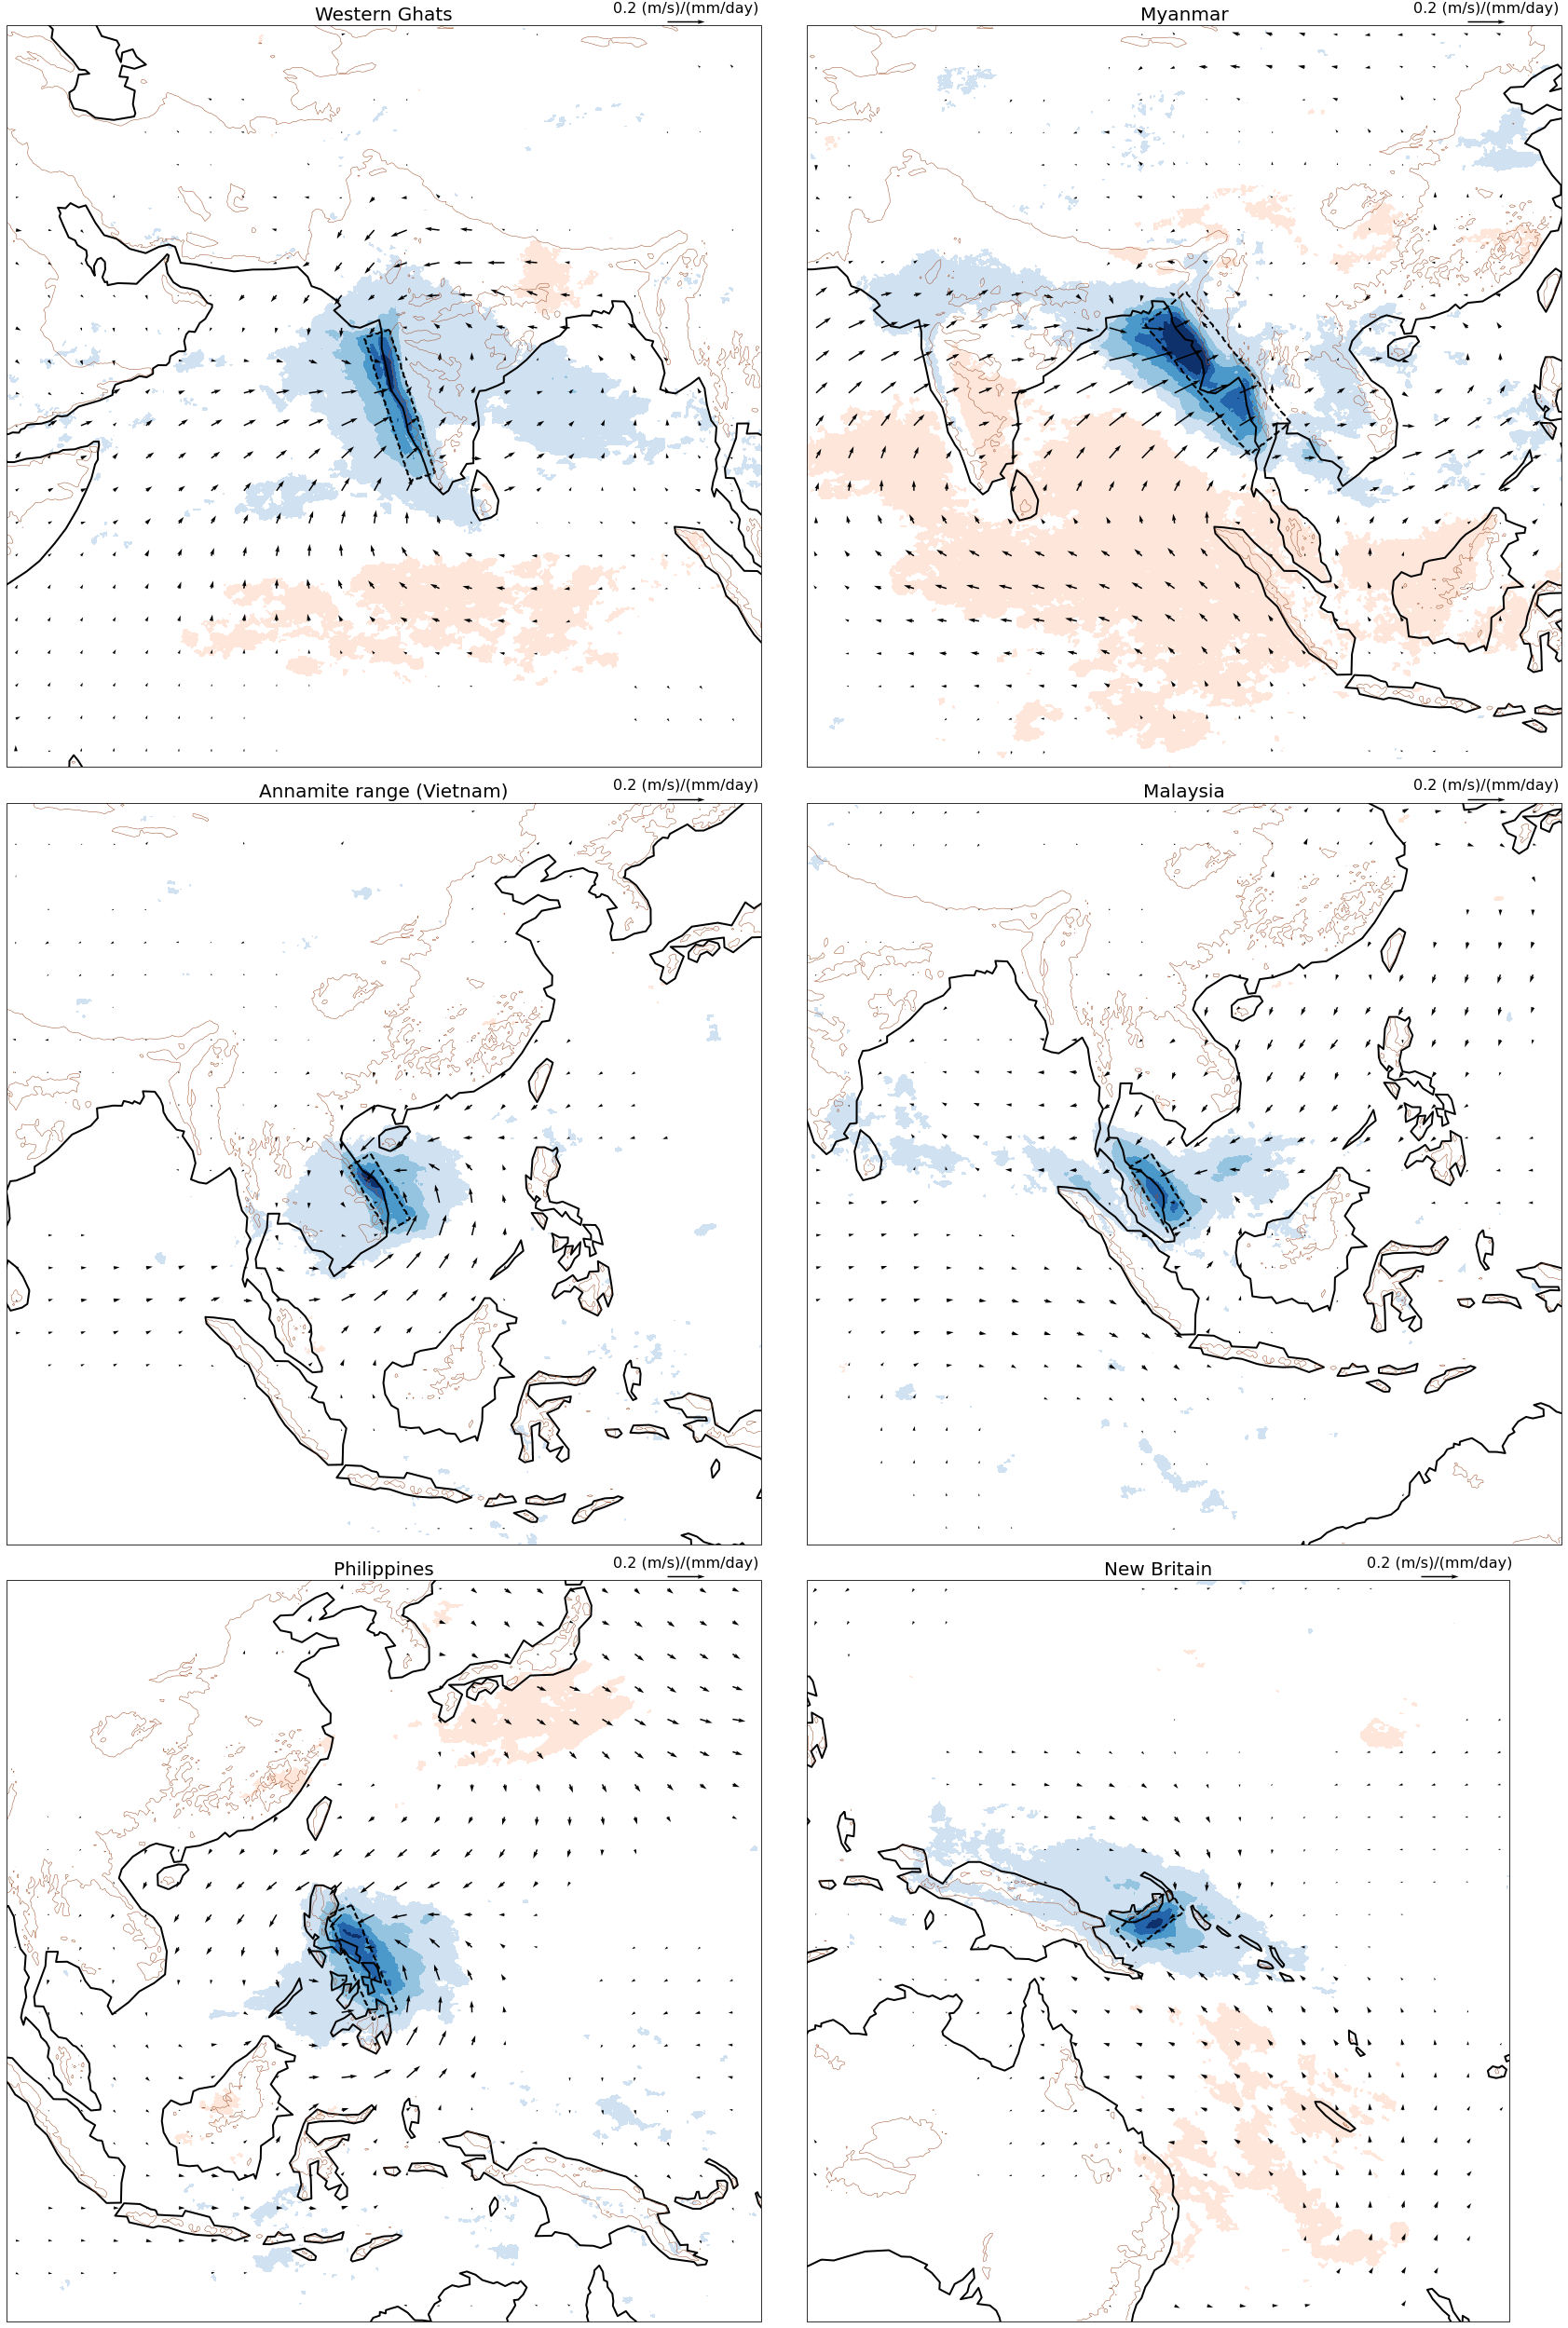

In [32]:
matplotlib.rcParams.update({'font.size': 16})

fig,axs = plt.subplots(3,2,figsize=(25,35),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.reshape(-1)
for i,MR in enumerate(MRs):
    ax=axs[i]
    ax.set_anchor('W')

    prreg = MR.vars['GPM_PR_REGRESSED']
    #prregpr = prreg.slope
    prregpr = (prreg.slope) / fdr_xr_2d(prreg.pvalue,0.01)
    prregpr[0,0]=1.7
    prregpr[-1,0]=-0.1
    c = prregpr.plot.contourf(ax=ax,add_colorbar=False,levels= np.arange(0,1.7,0.4),colors=('#FEE6DA','#D0E1F2','#95C4E0','#4A99CA','#2364AB','#0F316B'))
    
    tilted_rect(prreg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],linewidths=[2],colors=['k'])
    
    ureg = MR.vars['VAR_100U_REGRESSED']
    vreg = MR.vars['VAR_100V_REGRESSED']
    mask = (fdr_xr_2d(ureg.pvalue,0.01)+fdr_xr_2d(vreg.pvalue,0.01))>0
    u = ureg.slope / mask
    v = vreg.slope / mask
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=10
    m=n
    ibeg=3
    iend=-1
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",scale=0.005,width=1.5,units='dots',transform=ccrs.PlateCarree())
    qk = ax.quiverkey(Q, 0.9,1.005, 0.2, r'0.2 (m/s)/(mm/day)', labelpos='N',
                   coordinates='axes',color='k')
    

    sel_box(topo_midres,MR.bigbox).plot.contour(ax=ax,levels=[500.],colors=['sienna'],linewidths=[0.5])
    ax.coastlines(linewidth=2)
    ax.set_title(MR.Lname)
    ax.set_title(MR.Lname,fontsize=20)

fig.tight_layout()
